In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import cv2
import numpy as np

#Encoding and Split data into Train/Test Sets
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#Tensorflow Keras CNN Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop

#Plot Images
import matplotlib.pyplot as plt

2022-11-30 09:59:08.384422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Data

In [4]:
folder_dir = 'critter_data'
data = []
label = []

SIZE = 224 #Crop the image to 128x128

# set up labels from the name of each training photo folder
for folder in os.listdir(folder_dir):
    #ignore .DS_Store
    if not folder.startswith('.'):
        for file in os.listdir(os.path.join(folder_dir, folder)):
                # get jpegs 
                if not file.startswith('.'):
                    if file.endswith("jpg"):
                        #label with the folder name 
                        label.append(folder)
                        img = cv2.imread(os.path.join(folder_dir, folder, file))
                        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                        im = cv2.resize(img_rgb, (SIZE,SIZE))
                        data.append(im)
                    else:
                        continue

libpng warning: iCCP: extra compressed data


In [5]:
data_arr  = np.array(data)
label_arr = np.array(label)

encoder = LabelEncoder()
y = encoder.fit_transform(label_arr)
y = to_categorical(y, 5)


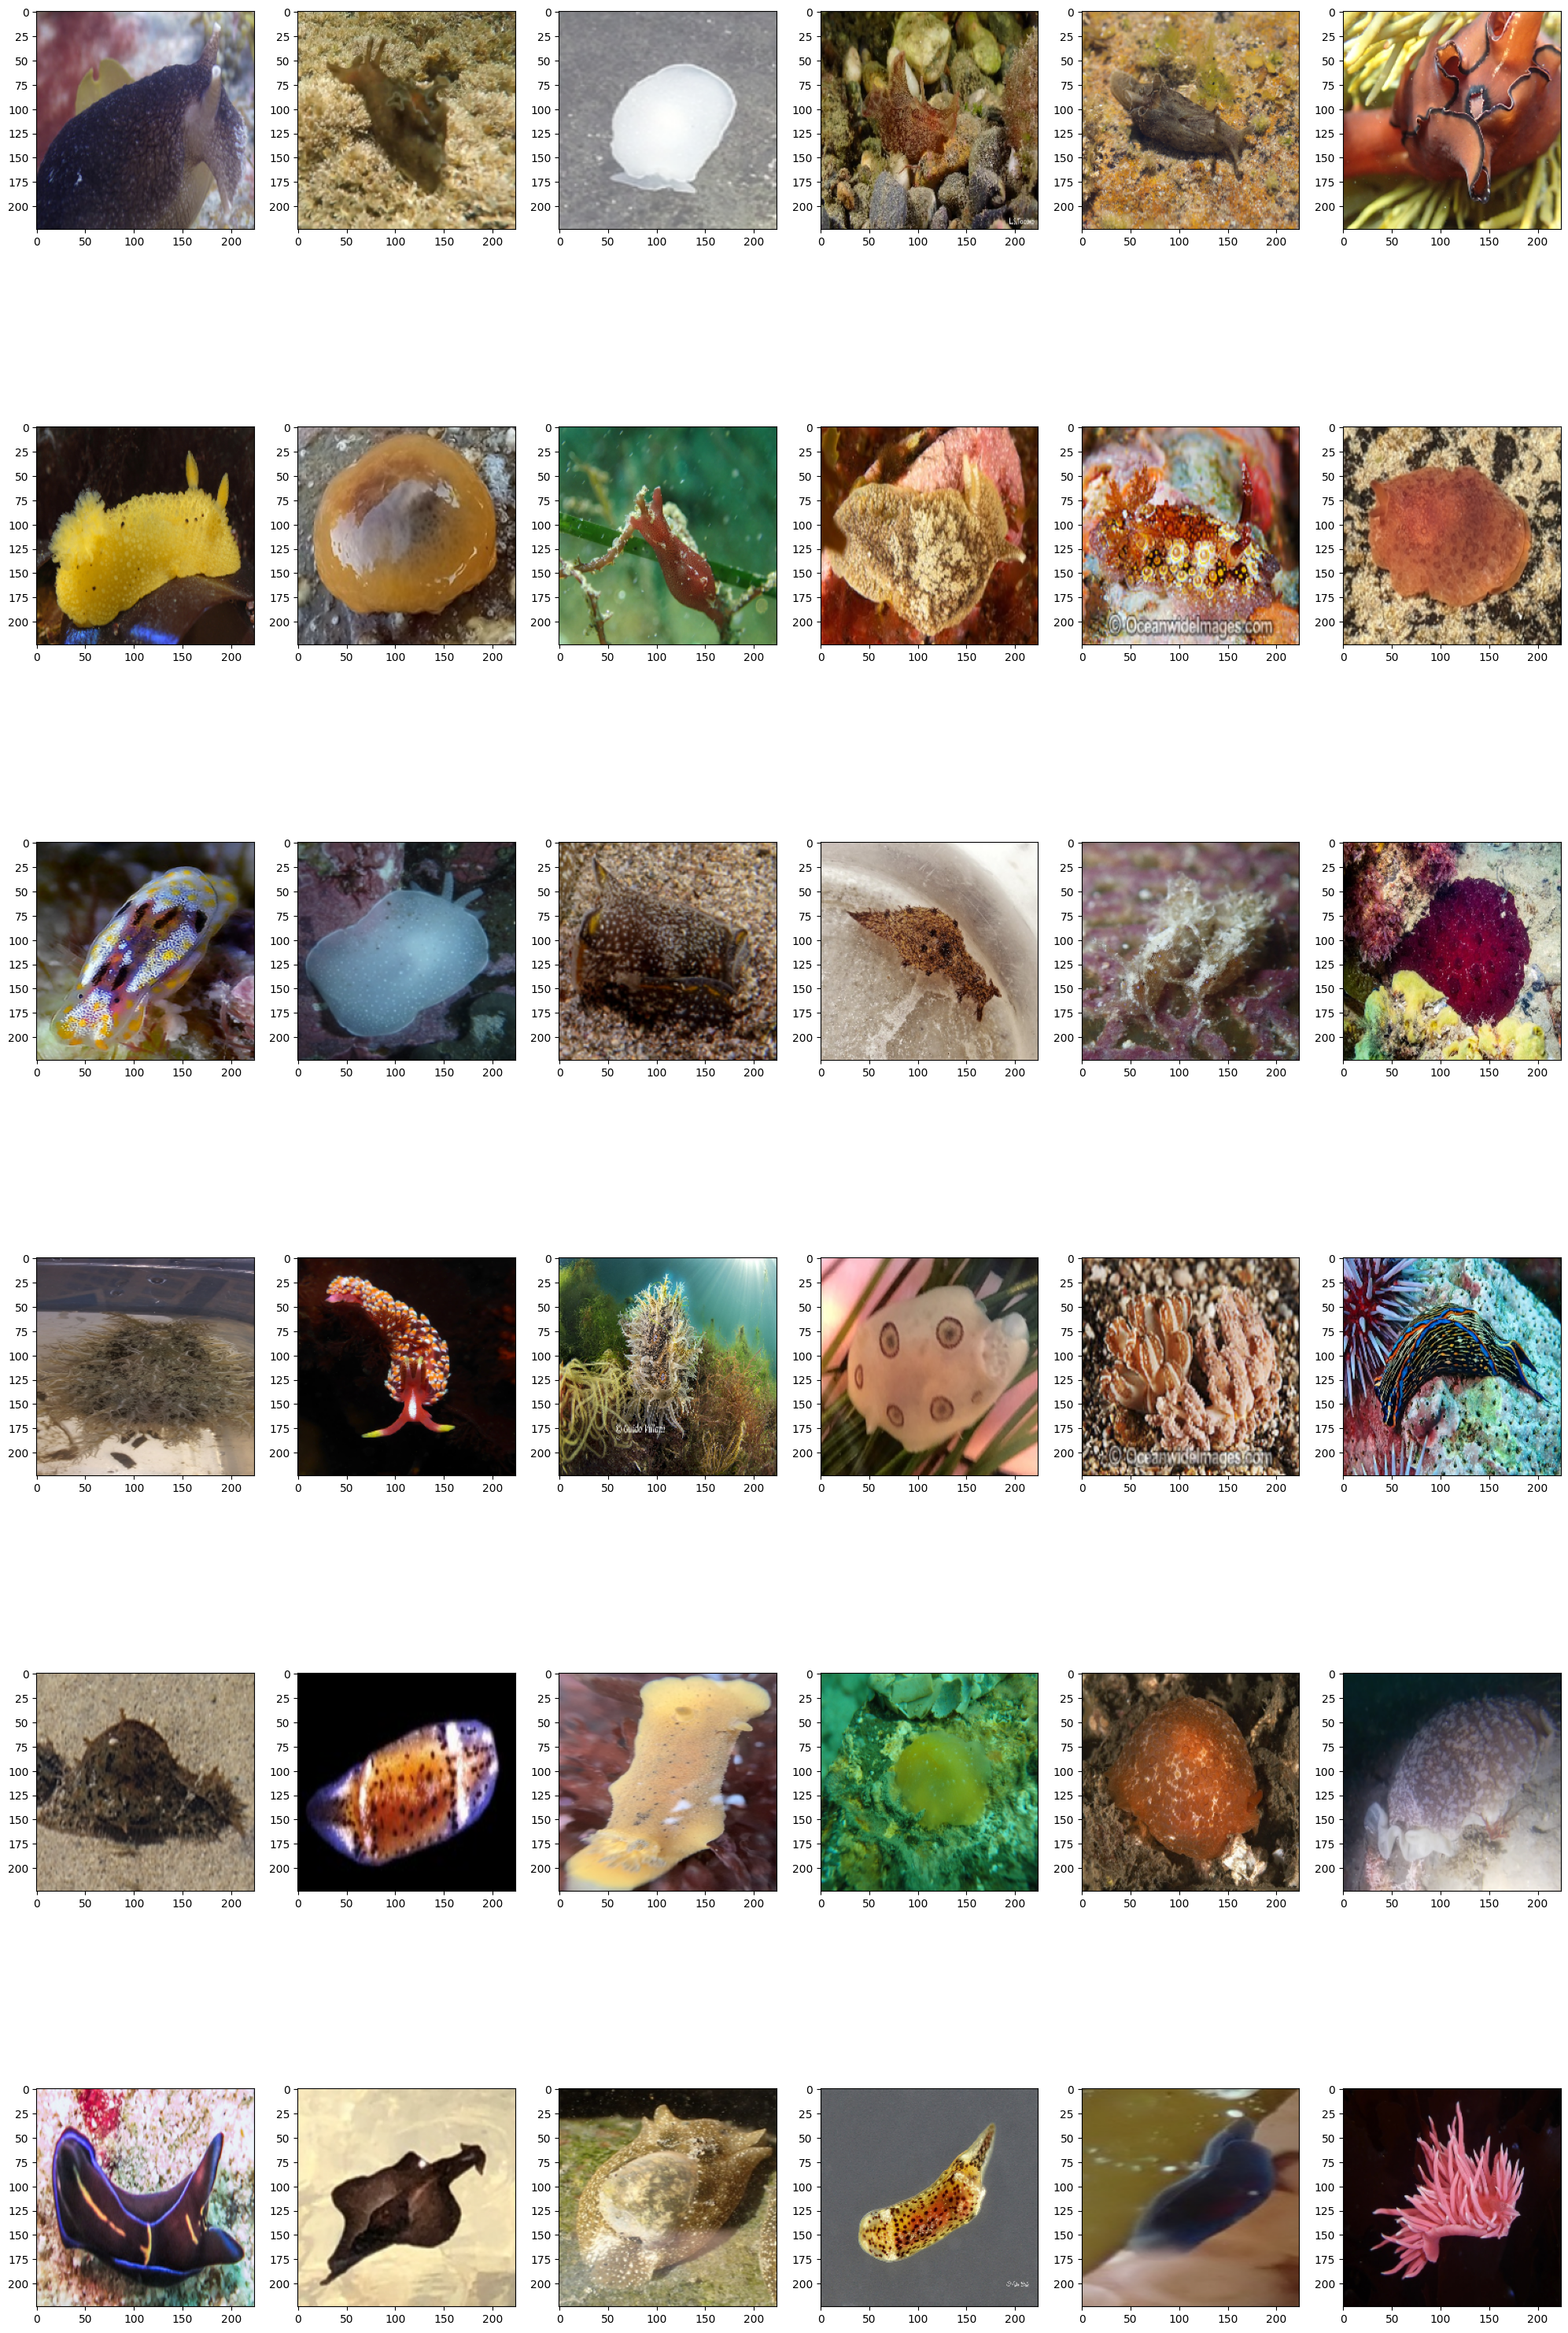

In [6]:
# set up 6x6 subplots 
fig, ax = plt.subplots(6,6, figsize=(25, 40))

for i in range(6):
    for j in range(6):
        k = int(np.random.random_sample() * len(data_arr))
        ax[i,j].imshow(np.array(data_arr)[k].reshape(SIZE, SIZE, 3), cmap='gray')
            

# Fine Tunning only flatten layer

Importing VGG16 Model that has been pretrained on the "imagenet" dataset to speed up training time

In [7]:
import tensorflow.keras, os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights

base_model.summary()


2022-11-30 10:01:35.257741: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

## Add the rest of the layers to the network

In [12]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

 ## Add optimizer and compile the model 

In [13]:
from tensorflow.keras.optimizers import Adam

opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])



### format X and Split training data

In [14]:
X = data_arr/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=10)


### Add Early stopping and fit model 

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])


## Save model 

In [35]:
model.save('model_ignore/VGG16_fine_tuning_1_no_augmentation')


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_1_no_augmentation/assets


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_1_no_augmentation/assets


In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

### Evaluate the Model 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

### Generate Predictions

In [26]:
y_pred=model.predict(X_test)

# reshape output data 
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)

#Generate the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

19/19 [==============================] - 51s 3s/step


In [27]:
cf_matrix.shape

(5, 5)

In [28]:
import seaborn as sns

### Plot Confusion Matrix

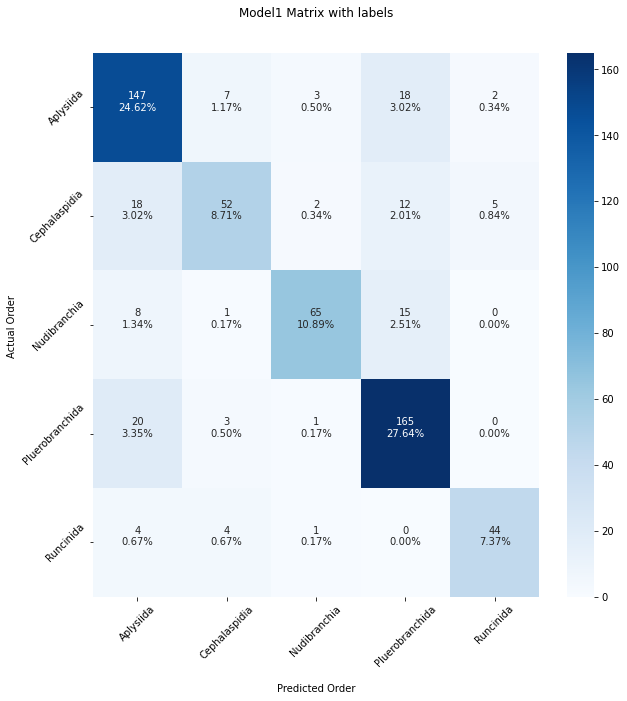

In [33]:
import matplotlib as mlp

fig = mlp.pyplot.gcf()
fig.set_size_inches(10, 10)

#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(5,5)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Model1 Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Order')
ax.set_ylabel('Actual Order ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Aplysiida','Cephalaspidia', 'Nudibranchia', 'Pluerobranchida', 'Runcinida'])
ax.yaxis.set_ticklabels(['Aplysiida','Cephalaspidia', 'Nudibranchia', 'Pluerobranchida', 'Runcinida'])

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=45)

## Display the visualization of the Confusion Matrix.
plt.show()

# Fine Tuning + CONV


In [16]:
from keras.models import Model


def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

### Resize images to fit input sizes to those of imagenet training photos  and add optimizer

In [17]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=5

n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)

### Add callbacks

In [20]:
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='model_ignore/tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

### Format and split data

In [ ]:
X = data_arr/255
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


## Fit Model 

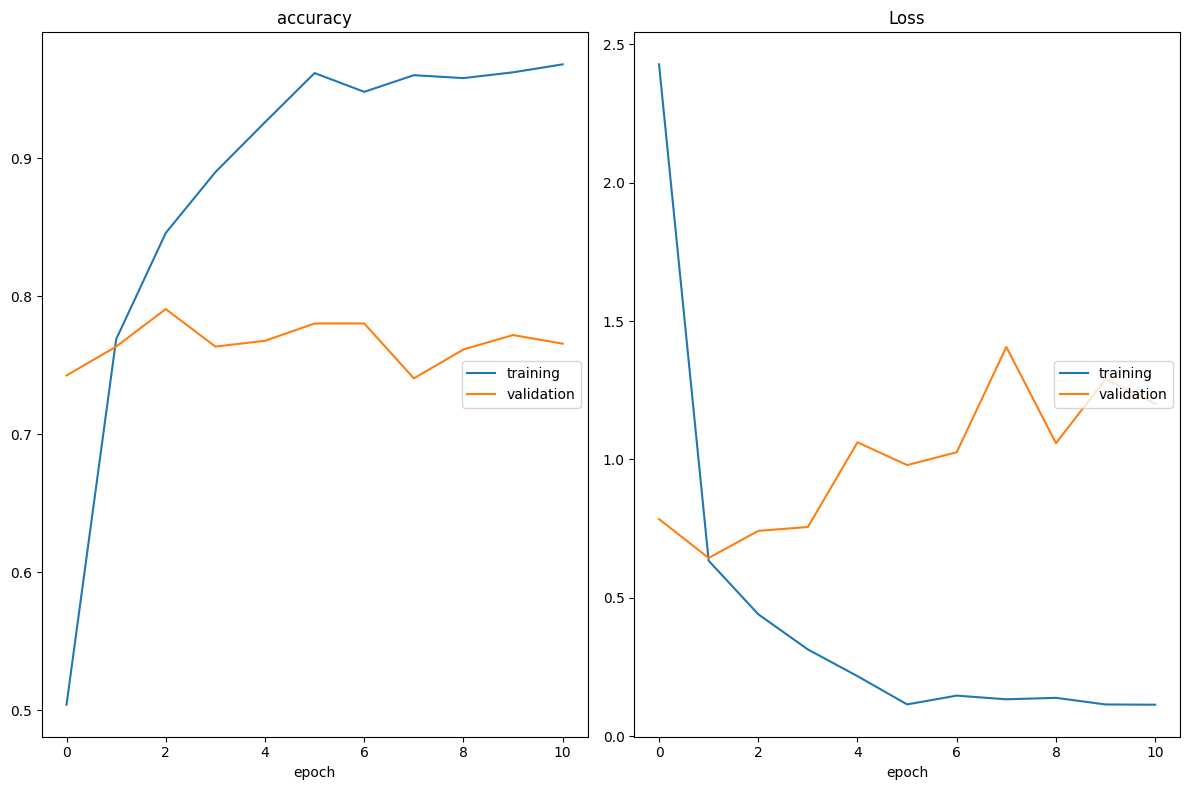

accuracy
	training         	 (min:    0.504, max:    0.968, cur:    0.968)
	validation       	 (min:    0.741, max:    0.791, cur:    0.766)
Loss
	training         	 (min:    0.114, max:    2.427, cur:    0.114)
	validation       	 (min:    0.644, max:    1.406, cur:    1.202)
60/60 [==============================] - 1409s 24s/step - loss: 0.1138 - accuracy: 0.9680 - val_loss: 1.2016 - val_accuracy: 0.7657
Epoch 12/25
58/60 [============================>.] - ETA: 39s - loss: 0.0738 - accuracy: 0.9768

In [ ]:

vgg_model.fit(X_train, y_train, epochs=25, validation_split=0.2, batch_size=32,
              callbacks=[tl_checkpoint_1, early_stop, plot_loss_1])

#### Save Model 

In [73]:
vgg_model.save('model_ignore/VGG16_fine_tuning_2_no_augmentation')


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_2_no_augmentation/assets


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_2_no_augmentation/assets


# Fine Tuning + Data Augmentation

In [78]:
BATCH_SIZE = 32

train_generator = ImageDataGenerator(rotation_range=90, 
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.20,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing



In [79]:

X = data_arr

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


traingen = train_generator.flow(X_train, y_train,
                               subset='training',
                               batch_size=BATCH_SIZE, 
                               shuffle=True,
                               seed=42)

validgen = train_generator.flow(X_train, y_train,
                               subset='validation',
                               batch_size=BATCH_SIZE,
                               shuffle=True,
                               seed=42)

testgen = test_generator.flow(X_test, y_test,
                             batch_size=1,
                             shuffle=False,
                             seed=42)

In [80]:
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=2)
opt = Adam(lr=0.0001)
vgg_model.compile(optimizer=opt, loss=tensorflow.keras.losses.categorical_crossentropy, metrics=['accuracy'])


In [ ]:
plot_loss_2 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_2 = ModelCheckpoint(filepath='VGG16_fine_tuning_2_yes_augmentation.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)


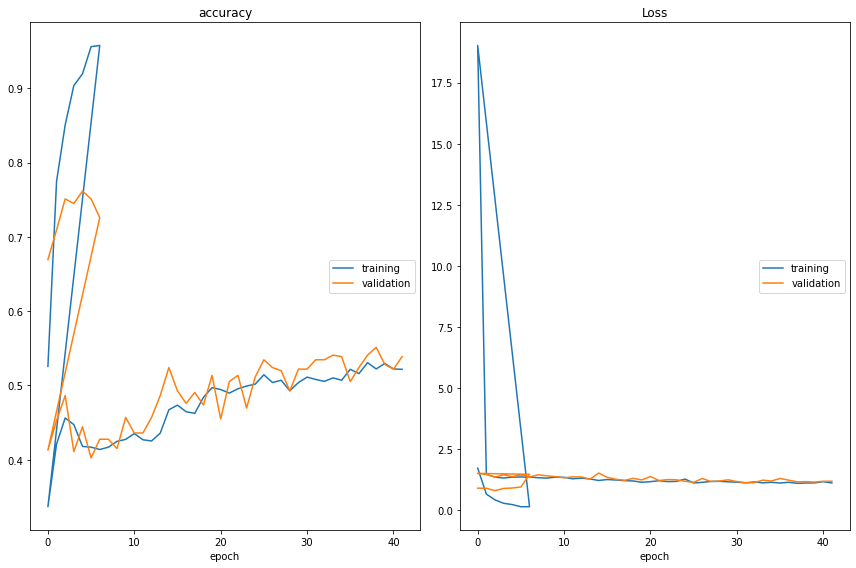

accuracy
	training         	 (min:    0.337, max:    0.958, cur:    0.522)
	validation       	 (min:    0.403, max:    0.762, cur:    0.539)
Loss
	training         	 (min:    0.134, max:   19.024, cur:    1.108)
	validation       	 (min:    0.793, max:    1.513, cur:    1.179)
60/60 [==============================] - 304s 5s/step - loss: 1.1077 - accuracy: 0.5217 - val_loss: 1.1787 - val_accuracy: 0.5388


In [81]:
vgg_model.fit(traingen, epochs=50, validation_data=validgen, batch_size=32,
              callbacks=[tl_checkpoint_2, early_stop, plot_loss_2])

In [82]:
vgg_model.save('Documents/CasonProject/VGG16_fine_tuning_2_yes_augmentation')


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_2_yes_augmentation/assets


INFO:tensorflow:Assets written to: Documents/CasonProject/VGG16_fine_tuning_2_yes_augmentation/assets
